In [1]:
import re
import numpy as np
import Model2d as m2
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import pandas as pd
from functools import reduce

## Construct cell network

In [4]:
sam = m2.Model2d()
sam.init_2d_dome_model()
sam.add_sp_pts(name='L1', ids=list(range(35, 51)))
sam.add_sp_pts(name='L26', ids=list(range(0, 35)))
sam.add_sp_pts(name='LR', ids=[47, 48, 49, 50, 35, 36, 37, 38])
sam.add_sp_pts(name='init_W', ids=[0,1,2,3,4,5,6,7,8,9,10,11])
sam.add_sp_pts(name='max_HAM', ids=list(set(range(51))-set(sam.sp_pts['L1'])-set([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])));

## Define the model

In [5]:
model_str = '''
    // Reactions:
    J00: -> W0;    kW*w0-bW*W0
    J01: -> c0;    -bc*c0
    J02: -> C0;    kC*c0-bC*C0
    J03: -> L0;    -bL*L0
    J04: -> w0;    -w0
    J05: -> H0;    -bH*H0

    // Variable Init:
    KcW=0.2; ncW=6;kc=0.5*1;
    KcL=0.24; ncL=6;
    KcH=0.13; ncH=4;
    kC=2.7; bc=0.5*1; bC=1;

    kwL=1; kwC=1;
    kw=1.2; KwW=0.53; nwW=2;
    KwL=0.29; nwL=6;
    KwC=0.15;
    nwC=6;
    kW=0.345;
    bW=0.4;
    k0w=0.3;
    ac=0;

    KHW=0.3; nHW=4; bH=1; kH=1;

    kL=10*1;
    bL=1.5*1;


    DW=1.0;DC=6;DL=1.2*1;
'''

sam.add_basal_str(model_str)

sam.expand_model()

sam.set_init({'init_W':{'w':0.1, 'W':0.1}})

sam.add_syn2model('L', 'LR', 'kL')
sam.add_syn2model('c', 'all', 'kc/((1+(Lxxx/KcL)^ncL))*(ac+(1-ac)*(Wxxx/KcW)^ncW/(1+(Wxxx/KcW)^ncW))/(1+(Hxxx/KcH)^ncH)')
sam.add_syn2model('w', 'L26', 'kw*(' + 'kwL/(1+(Lxxx/KwL)^nwL)' +'+'+ 'kwC/(1+(Cxxx/KwC)^nwC)' + ') *' + '(k0w+(Wxxx/KwW)^nwW/(1+(Wxxx/KwW)^nwW))')
sam.add_syn2model('H', 'max_HAM', 'kH*((Wxxx/KHW)^nHW/(1+(Wxxx/KHW)^nHW))')

sam.add_diff2model('L')
sam.add_diff2model('C')
sam.add_diff2model('W')

gene_names = ['EPFL', 'WUS protein', 'CLV3 protein', 'WUS mRNA', 'CLV3 mRNA', 'HAM-WUS signaling']

## Run simulations for all genotypes

In [6]:
gtypes = {'WT':{},
        r'$\it{wus}$'+'\nmutant':{'kw':0},
        r'$\it{erf}$'+'\nmutant':{'kL':0},r'$\it{erf&clv3}$'+'\nmutant':{'kL':0, 'kc':0},
        r'$\it{clv3}$'+'\nmutant':{'kc':0}, r'$\it{ham}$'+'\nmutant':{'kH':0},
        r'$\it{ham&erf}$'+'\nmutant':{'kL':0,'kH':0}}

typenames = ['WT',
    r'$\it{wus}$'+'\nmutant',
    r'$\it{erf}$'+'\nmutant', r'$\it{clv3}$'+'\nmutant',
    r'$\it{erf&clv3}$'+'\nmutant', r'$\it{ham}$'+'\nmutant',
    r'$\it{ham&erf}$'+'\nmutant']

sim_data = []
for i, name in enumerate(typenames[:]):
    cond = gtypes[name]
    m, mr, tps = sam.run_sim(cond)
    sim_data.append(mr)
sim_data = np.array(sim_data)

## Plot steady state distributions for all genotypes

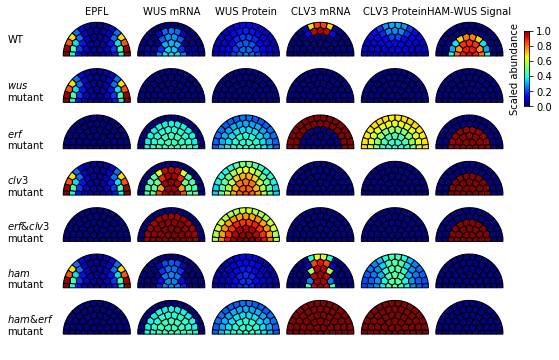

In [7]:
sam.plot_all_gts(data_all=sim_data, gtypes=typenames, norm_all=True)

## Define lateral and middle regions

In [11]:
sam.add_sp_pts(name='mid', ids=[0, 1, 2, 3, 4, 7, 8, 9, 16, 17, 27, 28, 29, 41, 42, 43, 44])
sam.add_sp_pts(name='lat', ids=[10, 11, 18, 19, 20, 21, 30, 31, 32, 33, 34, 45, 46, 47, 48, 49, 50, 5, 6, 12, 13, 14, 15, 22, 23, 24, 25, 26, 35, 36, 37, 38, 39, 40]);

## Quantify WUS and CLV3 mRNA in lateral and middle regions

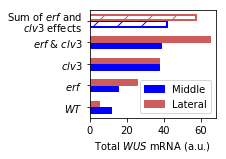

In [14]:
wus_tt = np.zeros((2, len(sim_data)))
for i, d in enumerate(sim_data[[0,2,3,4]]):
    name = typenames[i].replace('\n', ' ').replace('$', '').replace('{', '').replace('}', '').replace('\\', '').replace('it', '')
    wus_lat_tt = (d[3, -1, sam.sp_pts['lat']]).sum()
    wus_mid_tt = (d[3, -1, sam.sp_pts['mid']]).sum()
    wus_tt[1, i] = wus_lat_tt
    wus_tt[0, i] = wus_mid_tt

fig, ax = plt.subplots(figsize=(3.5,2.0))
fig.subplots_adjust(left=0.40, bottom=0.24, top=0.99)
ax.barh(np.arange(4)-0.15, wus_tt[0,:4], height=0.25, ec='b', fc='b', label='Middle')
ax.barh(np.arange(4)+0.15, wus_tt[1,:4], height=0.25, ec='indianred', fc='indianred', label='Lateral')
sum_mid = wus_tt[0,2]+wus_tt[0,1]-wus_tt[0,0]
sum_lat = wus_tt[1,2]+wus_tt[1,1]-wus_tt[1,0]
ax.barh([4-0.15], [sum_mid], height=0.25, ec='b', color='w', hatch='/', lw=2)
ax.barh([4+0.15], [sum_lat], height=0.25, ec='indianred',fc='w', hatch='/', lw=2)

ax.legend(prop={'size':10}, ncol=1)
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels([r'$WT$', r'$\it{erf}$', r'$\it{clv3}$', r'$\it{erf}$ & $\it{clv3}$', r'Sum of $\it{erf}$'+' and\n'+r'$\it{clv3}$ effects'], ha='right', linespacing=0.9)
ax.set_xlabel(r'Total $\it{WUS}$ mRNA (a.u.)');


## Perturbing EPFL regulation on CLV3 and WUS separately

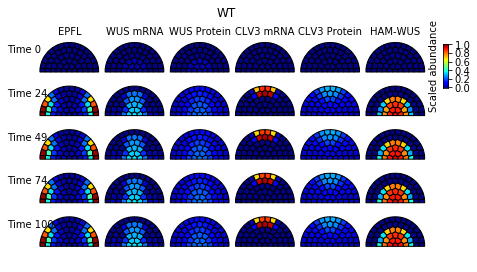

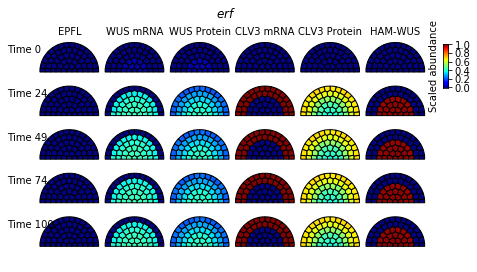

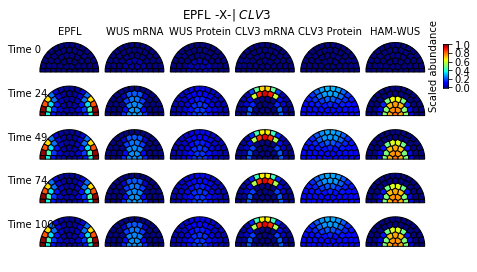

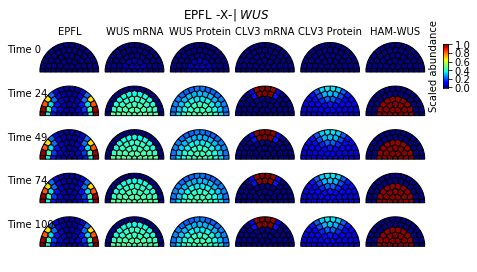

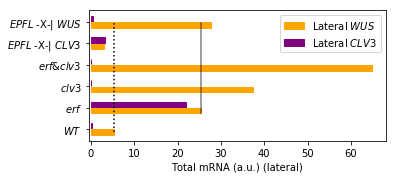

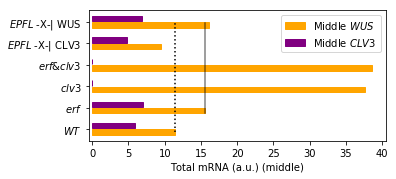

In [15]:
m, mr, tps = sam.run_sim(gene_names=gene_names, conds={})
sam.plot_tps(mr, tps, 'WT', norm=sim_data)

m, mr, tps = sam.run_sim(gene_names=gene_names, conds={'kL':0})
sam.plot_tps(mr, tps, r'$\it{erf}$', norm=sim_data)

sim_data2 = []
m, mr, tps = sam.run_sim(gene_names=gene_names, conds={'KcL':1000})
sam.plot_tps(mr, tps, r'EPFL -X-| $\it{CLV3}$', norm=sim_data)
sim_data2.append(mr)


m, mr, tps = sam.run_sim(gene_names=gene_names, conds={'KwL':1000})
sam.plot_tps(mr, tps, r'EPFL -X-| $\it{WUS}$', norm=sim_data)
sim_data2.append(mr)


sim_data2 = np.array(sim_data2)
sim_data12 = np.concatenate((sim_data[[0,2,3,4]], sim_data2))

fig2, ax = plt.subplots(figsize=(5.5,2.3))
fig2.subplots_adjust(left=0.24, right=0.99, bottom=0.2, top=0.99)
ax.barh(np.arange(6)-0.15, sim_data12[:, 3, -1, sam.sp_pts['lat']].sum(axis=-1), height=0.25, ec='orange', fc='orange', label=r'Lateral $\it{WUS}$')
ax.barh(np.arange(6)+0.15, sim_data12[:, 4, -1, sam.sp_pts['lat']].sum(axis=-1), height=0.25, ec='purple', fc='purple', label=r'Lateral $\it{CLV3}$')
ax.axvline(sim_data12[0, 3, -1, sam.sp_pts['lat']].sum(axis=-1),ymin=0.07,ymax=0.9, ls=':', color='k')
ax.axvline(sim_data12[1, 3, -1, sam.sp_pts['lat']].sum(axis=-1),ymin=0.21,ymax=0.9, ls='-', color='k', alpha=0.5)
ax.set_xlim(-0.5, None)
ax.set_yticks([0, 1, 2, 3, 4, 5])
ax.set_yticklabels([r'$WT$', r'$\it{erf}$', r'$\it{clv3}$', r'$\it{erf} & \it{clv3}$', r'$EPFL$ -X-| $\it{CLV3}$', r'$EPFL$ -X-| $\it{WUS}$'], ha='right')
ax.set_xlabel('Total mRNA (a.u.) (lateral)')
ax.legend(loc=1, ncol=1)

fig3, ax = plt.subplots(figsize=(5.5,2.3))
fig3.subplots_adjust(left=0.24, right=0.99, bottom=0.2, top=0.99)

ax.barh(np.arange(6)-0.15, sim_data12[:, 3, -1, sam.sp_pts['mid']].sum(axis=-1), height=0.25, ec='orange', fc='orange', label=r'Middle $\it{WUS}$')
ax.barh(np.arange(6)+0.15, sim_data12[:, 4, -1, sam.sp_pts['mid']].sum(axis=-1), height=0.25, ec='purple', fc='purple', label=r'Middle $\it{CLV3}$')
ax.axvline(sim_data12[0, 3, -1, sam.sp_pts['mid']].sum(axis=-1),ymin=0.07,ymax=0.9, ls=':', color='k')
ax.axvline(sim_data12[1, 3, -1, sam.sp_pts['mid']].sum(axis=-1),ymin=0.21,ymax=0.9, ls='-', color='k', alpha=0.5)
ax.set_xlim(-0.5, None)
ax.set_yticks([0, 1, 2, 3, 4, 5])
ax.set_yticklabels([r'$WT$', r'$\it{erf}$', r'$\it{clv3}$', r'$\it{erf} & \it{clv3}$', r'$EPFL$ -X-| CLV3', r'$EPFL$ -X-| WUS'], ha='right')
ax.set_xlabel('Total mRNA (a.u.) (middle)')
ax.legend(loc=1, ncol=1);

## Simulate NFL-KO and PFL-KO models

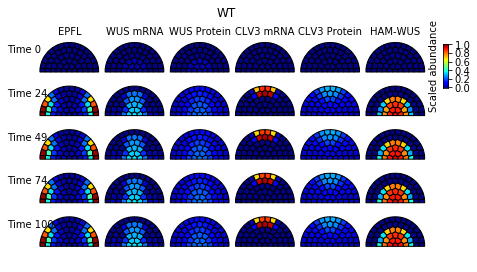

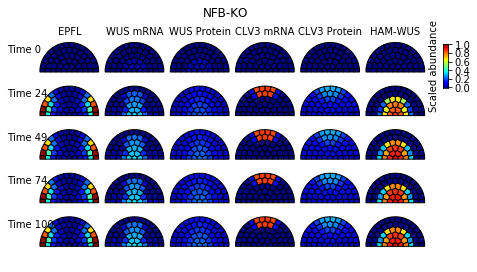

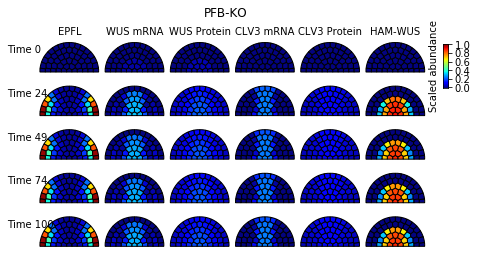

In [20]:
m, mr, tps = sam.run_sim(gene_names=gene_names, conds={})
sam.plot_tps(mr, tps, 'WT', norm=sim_data)

m, mr, tps = sam.run_sim(gene_names=gene_names, conds={'KcW':1000, 'ac': 1, 'kc':sam.r.kc*0.85})
sam.plot_tps(mr, tps, 'NFL-KO', norm=sim_data)

m, mr, tps = sam.run_sim(gene_names=gene_names, conds={'KcH':1000, 'kc':sam.r.kc*0.25})
sam.plot_tps(mr, tps, 'PFL-KO', norm=sim_data)

## Compare WT, NFL-KO and PFL-KO models in maintaining WUS expression

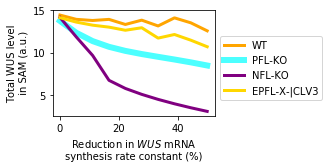

In [22]:
xs = []
perts = np.linspace(0, 0.5, 10)
for paw0 in perts:
    #print('WT', end='\t')
    m, mr, tps = sam.run_sim(gene_names=gene_names, conds={'kw':sam.r.kw*(1-paw0)})
    wus_wt = mr[1, -1, :].sum()
    #print("%.2f"%wus_wt, end='\t')

    #print('No NFB', end='\t')
    m, mr, tps = sam.run_sim(gene_names=gene_names, conds={'KcW':1000, 'ac': 1, 'kc':sam.r.kc*0.85,'kw':sam.r.kw*(1-paw0)})
    #sam.plot_tps(mr, tps, 'No WUS -| CLV3', norm=sim_data)
    wus_ko = mr[1, -1, :].sum()
    #print("%.2f"%wus_ko, end='\t')

    #print('No PFB', end='\t')
    m, mr, tps = sam.run_sim(gene_names=gene_names, conds={'KcH':1000, 'kc':sam.r.kc*0.25, 'kw':sam.r.kw*(1-paw0)})
    wus_ko2 = mr[1, -1, :].sum()
    #print("%.2f"%wus_ko2)

    m, mr, tps = sam.run_sim(gene_names=gene_names, conds={'kL':0,'kw':sam.r.kw*(1-paw0), 'kW':sam.r.kW*0.7})
    wus_eko = mr[1, -1, :].sum()
    m, mr, tps = sam.run_sim(gene_names=gene_names, conds={'KcL':1000,'kw':sam.r.kw*(1-paw0), 'kc':sam.r.kc*0.5})
    wus_ecko = mr[1, -1, :].sum()
    m, mr, tps = sam.run_sim(gene_names=gene_names, conds={'KwL':1000,'kw':sam.r.kw*(1-paw0), 'kW':sam.r.kW*0.47})
    wus_ewko = mr[1, -1, :].sum()

    xs.append([wus_wt, wus_ko, wus_ko2, wus_eko, wus_ecko, wus_ewko])

xs = np.array(xs).T

fig, ax = plt.subplots(figsize=(5.0,2.3))
fig.subplots_adjust(left=0.15, bottom=0.31, top=0.95, right=0.6)
ax.plot(perts, xs[0], label='WT', lw=3, c='orange')
ax.plot(perts, xs[2], label='PFL-KO', lw=6, c='cyan', alpha=0.7)
ax.plot(perts, xs[1], label='NFL-KO', lw=3, c='purple')

ax.plot(perts, xs[4], label='EPFL-X-|CLV3', lw=3, c='gold')

ax.set_xlabel(r'Reduction in $\it{WUS}$ mRNA'+'\nsynthesis rate constant (%)')
ax.set_ylabel('Total WUS level\n in SAM (a.u.)')
ax.set_xticklabels([0, 0, 20, 40])
ax.legend(bbox_to_anchor=(1, 0.7, 0.1, 0.1))

## Compare three models in cell diversity

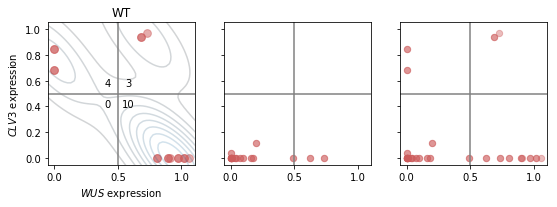

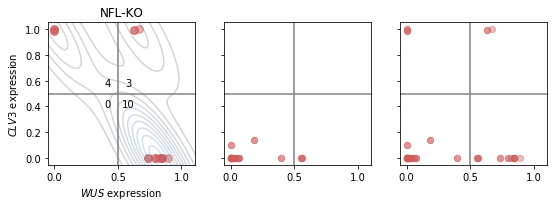

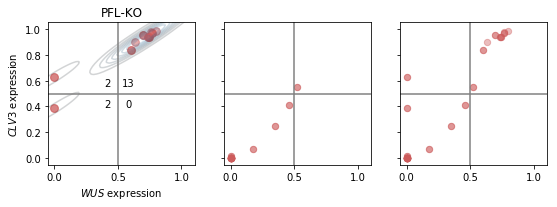

In [24]:
for name, cond in zip(['WT', 'NFL-KO', 'PFL-KO'], [{}, {'KcW':1000, 'ac':1}, {'KcH':1000}]):
    fig, axs = plt.subplots(figsize=(9,3), ncols=3)
    fig.subplots_adjust(left=0.13, bottom=0.22)
    ax1, ax2, ax3 = axs[0], axs[1], axs[2]

    m, mr, tps = sam.run_sim(gene_names=gene_names, conds=cond)

    x = mr[3:5, -1, sam.sp_pts['mid']]
    ax1.scatter(x[0], x[1], alpha=0.5, c='indianred', s=60)
    sns.kdeplot(x[0], x[1], ax=ax1, alpha=0.2)
    cut = 0.5
    w_on = ((x[0]>cut) & (x[1]<cut)).sum()
    c_on = ((x[0]<cut) & (x[1]>cut)).sum()
    dp = ((x[0]>cut) & (x[1]>cut)).sum()
    dn = ((x[0]<cut) & (x[1]<cut)).sum()
    os = 0.08
    ax1.set_title(name)
    ax1.text(cut-os, cut-os*1, dn, ha='center', va='center')
    ax1.text(cut+os, cut+os*1, dp, ha='center', va='center')
    ax1.text(cut-os, cut+os*1, c_on, ha='center', va='center')
    ax1.text(cut+os, cut-os*1, w_on, ha='center', va='center')
    ax1.set_xlabel(r'$\it{WUS}$ expression')
    ax1.set_ylabel(r'$\it{CLV3}$ expression')

    y = mr[3:5, -1, sam.sp_pts['lat']]
    ax2.scatter(y[0], y[1], alpha=0.4, c='indianred', s=40)

    z = mr[3:5, -1, :]
    ax3.scatter(z[0], z[1], alpha=0.4, c='indianred', s=40)

    for ax in axs:
        ax.axvline(cut, c='gray')
        ax.axhline(cut, c='gray')
        ax.set_xlim(-0.05, 1.105)
        ax.set_ylim(-0.05, 1.05)
    for ax in (ax2, ax3):
        ax.set_yticklabels([])

## Define three performance metrics

In [25]:
def compute_cc(cond, gene_pair=[], region=''):
    m, mr, tps = sam.run_sim(gene_names=gene_names, conds=cond)
    cut = 0.50
    low1 = np.where(mr[gene_pair[1], -1, sam.sp_pts[region]]<cut)[0]
    y = (mr[gene_pair[0], -1, sam.sp_pts[region]][low1]>cut).sum()

    low0 = np.where(mr[gene_pair[0], -1, sam.sp_pts[region]]<cut)[0]
    z = (mr[gene_pair[1], -1, sam.sp_pts[region]][low0]>cut).sum()
    r = -y-z + abs(y-z)
    return r, mr

def compute_tt(cond={}, data=[], gene=None, region=''):
    if len(data)==0:
        m, data, tps = sam.run_sim(gene_names=gene_names, conds=cond)
    return data[:, -1, sam.sp_pts[region]][gene].sum()

def compute_cv(cond={}):
    perts = np.linspace(0.00, 0.5, 10)
    xs = []
    for paw0 in perts:
        m, mr, tps = sam.run_sim(gene_names=gene_names, conds={'kw':sam.r.kw*(1-paw0), **cond})
        wus_wt = mr[1, -1, :].sum()
        xs.append(wus_wt)
    xs = np.array(xs)
    cv = xs.std() / xs.mean()
    diff = np.abs(xs[1:] - xs[0]).sum() / xs[0]
    return diff

## Perturbing all parameters

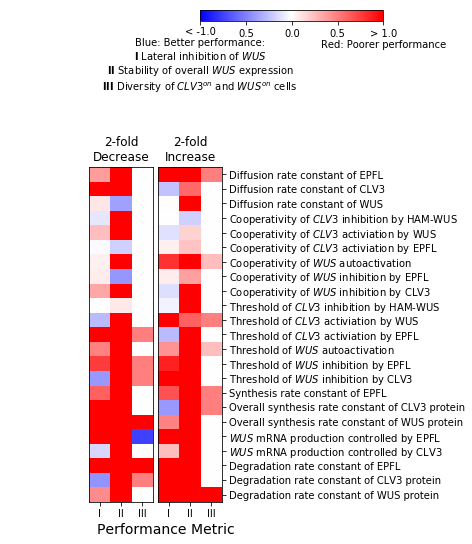

In [27]:
def perf_perturb_pars(sel_pars=[], fold=1, refs=[], if_print=True):
    perf_mx = np.zeros((3, len(sel_pars)))
    for i, (p, name) in enumerate(sel_pars):
            condp = {p:sam.r[p]*fold}
            cc, data = compute_cc(cond=condp, gene_pair=[3,4], region='mid')

            det_cc = (cc-refs[2])/abs(refs[2])
            lat_tt = compute_tt(data=data, region='lat', gene=3)

            det_tt = (lat_tt-refs[0])/refs[0]
            cv = compute_cv(cond=condp)
            det_cv = (cv-refs[1])/abs(refs[1])
            if if_print:
                print(p, end='\t')
                print("%.2f" % det_tt, end='\t')
                print("%.2f" % det_cv, end='\t')
                print("%.2f" % det_cc, end='\n')

            perf_mx[:, i] = [det_tt, det_cv, det_cc]
    return perf_mx

sel_pars = [
    ['bW', r'Degradation rate constant of WUS protein'],
    ['bC', r'Degradation rate constant of CLV3 protein'],
    ['bL', r'Degradation rate constant of EPFL'],
    ['kwC', r'$\it{WUS}$ mRNA production controlled by CLV3'],
    ['kwL', r'$\it{WUS}$ mRNA production controlled by EPFL'],
    ['kW', 'Overall synthesis rate constant of WUS protein'],
    ['kC', 'Overall synthesis rate constant of CLV3 protein'],
    ['kL', 'Synthesis rate constant of EPFL'],
    ['KwC', r'Threshold of $\it{WUS}$ inhibition by CLV3'],
    ['KwL', r'Threshold of $\it{WUS}$ inhibition by EPFL'],
    ['KwW', r'Threshold of $\it{WUS}$ autoactivation'],
    ['KcL', r'Threshold of $\it{CLV3}$ activiation by EPFL'],
    ['KcW', r'Threshold of $\it{CLV3}$ activiation by WUS'],
    ['KcH', r'Threshold of $\it{CLV3}$ inhibition by HAM-WUS'],
    ['nwC', r'Cooperativity of $\it{WUS}$ inhibition by CLV3'],
    ['nwL', r'Cooperativity of $\it{WUS}$ inhibition by EPFL'],
    ['nwW', r'Cooperativity of $\it{WUS}$ autoactivation'],
    ['ncL', r'Cooperativity of $\it{CLV3}$ activiation by EPFL'],
    ['ncW', r'Cooperativity of $\it{CLV3}$ activiation by WUS'],
    ['ncH', r'Cooperativity of $\it{CLV3}$ inhibition by HAM-WUS'],
    ['DW', 'Diffusion rate constant of WUS'],
    ['DC', 'Diffusion rate constant of CLV3'],
    ['DL', 'Diffusion rate constant of EPFL'],
]

cc_ref, data = compute_cc({}, gene_pair=[3,4], region='mid')

lat_ref = compute_tt(data=data, region='lat', gene=3)

cv_ref = compute_cv()

refs = [lat_ref, cv_ref, cc_ref]

perf_mx_05 = perf_perturb_pars(sel_pars=sel_pars, fold=0.5, refs=refs, if_print=False)
perf_mx_2 = perf_perturb_pars(sel_pars=sel_pars, fold=2, refs=refs, if_print=False)

fig, axs = plt.subplots(figsize=(6.7,7.5), ncols=2)
fig.subplots_adjust(left=0.02, right=0.295, wspace=0.085,\
        top=0.7, bottom=0.08)
ax1, ax2 = axs[0], axs[1]
im = ax1.imshow(perf_mx_05.T, cmap='bwr', vmin=-1.0, vmax=1.0, origin='lower', aspect='auto')
ax2.imshow(perf_mx_2.T, cmap='bwr', vmin=-1.0, vmax=1.0, origin='lower', aspect='auto')
ax2.yaxis.tick_right()
for ax in axs:
    ax.set_xticks([0, 1, 2])
    ax.set_yticks(range(len(sel_pars)))
    ax.set_xticklabels(['I', 'II', 'III'])
ax1.set_yticks([])
ax2.set_yticklabels([x[1] for x in sel_pars])
ax1.set_xlabel(' '*20 + 'Performance Metric', size=14)
ax1.set_title('2-fold\nDecrease')
ax2.set_title('2-fold\nIncrease')

cax = fig.add_axes([0.25,0.97,0.38,0.02])
fig.colorbar(im, cax=cax, orientation='horizontal')
cax.set_xticklabels(['< -1.0\nBlue: Better performance:\n'+r'$\bf{I}$ Lateral inhibition of $\it{WUS}$'+'\n'+r'$\bf{II}$ Stability of overall $\it{WUS}$ expression'+'\n'+r'$\bf{III}$ Diversity of $\it{CLV3}^{on}$ and $\it{WUS}^{on}$ cells', '0.5', '0.0', '0.5', '> 1.0\nRed: Poorer performance']);